In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers seqeval[gpu] -q
!pip install fairseq -q
!pip install fastBPE -q
!pip install pytorch-crf -q

     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
     |████████████████████████████████| 596 kB 20.5 MB/s 
     |████████████████████████████████| 61 kB 247 kB/s 
     |████████████████████████████████| 3.3 MB 34.7 MB/s 
     |████████████████████████████████| 895 kB 16.5 MB/s 
     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 90 kB 8.6 MB/s 
     |████████████████████████████████| 145 kB 52.5 MB/s 
     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 112 kB 49.7 MB/s 


In [3]:
%cd /content/drive/MyDrive/NLP/project_nlp

/content/drive/MyDrive/NLP/project_nlp


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchcrf import CRF

from transformers import RobertaConfig, RobertaPreTrainedModel, RobertaModel, RobertaForTokenClassification
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule
from transformers.modeling_outputs import TokenClassifierOutput

import seqeval
from seqeval.metrics import classification_report, f1_score

import pandas as pd
import numpy as np
import argparse
import time
import tqdm

from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary

from sklearn.utils.class_weight import compute_class_weight

from src.dataset import *

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## DATA - HERE

In [6]:
data = pd.read_csv('./data/joint/data_joint.csv')
data

,Unnamed: 0,sentence,word_labels,label
0,0,"combo 3 cái giao có 1 cái , thành_ra đặt 6 cái...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-DES,B-DE...",-1
1,1,mình mua áo có cổ màu trắng lại ship tới cho m...,"O,O,B-DES,B-DES,I-DES,B-DES,I-DES,O,O,O,O,O,B-...",-1
2,2,giao sai hàng . tôi muốn trả hàng . đặt be đậm...,"O,O,O,O,O,O,O,O,O,O,B-DES,I-DES,O,B-DES,I-DES",-1
3,3,sản_xuất việt_nam nhưng thấy in chữ trung_quốc...,"O,O,O,O,B-DES,I-DES,O,O,O,O,O,O,O",-1
4,4,mình đặt áo sơ_mi trắng dài tay mà shop giao c...,"O,O,B-DES,I-DES,B-DES,B-DES,I-DES,O,O,O,O,O,O,...",-1
...,...,...,...,...
3652,3652,chất_lượng sản_phẩm giống mô tả . giao hàng nh...,"O,O,O,O,O,O,O,O,O,O",1
3653,3653,"hài_lòng vô_cùng , giao nhanh , nhân_viên giao...","O,O,O,O,O,O,O,O,O,O,O,B-DES,O,B-DES",1
3654,3654,sản_phẩm ổn . giá phải_chăng . thật_sự là nhận...,"O,O,O,B-PRI,B-PRI,O,O,O,O,O,O,O,O,O,O,O,O,O",1
3655,3655,hàng đẹp chuẩn chất_lượng . nếu áo có đai ngan...,"O,B-DES,O,O,O,O,B-DES,O,O,O,B-DES,O,B-DES,O,O,O",1


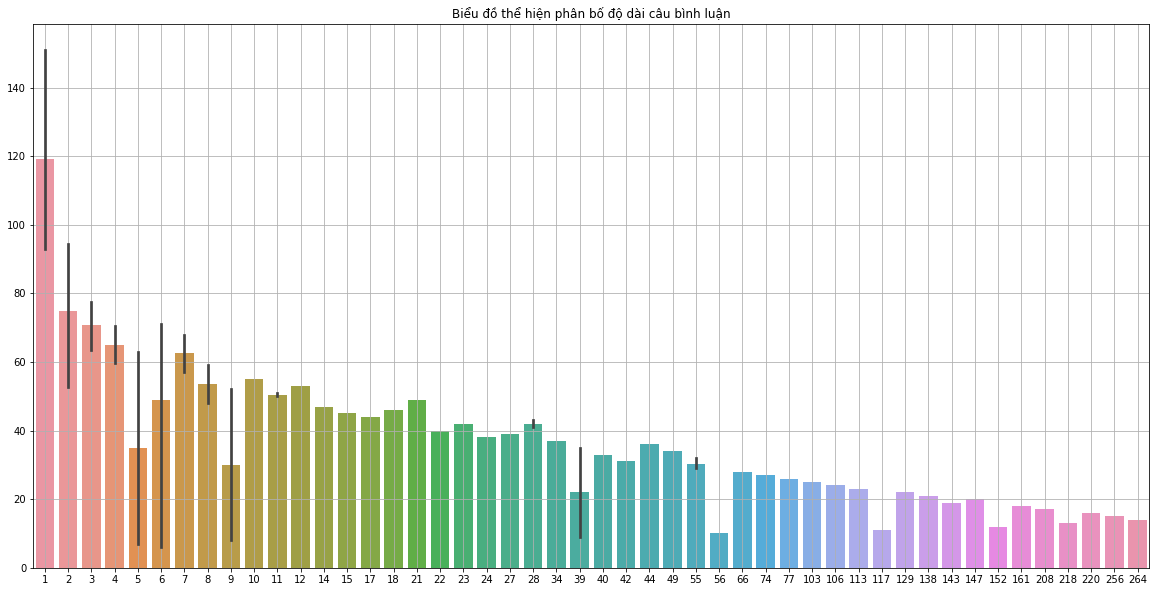

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,10))
sns.barplot(x=data.sentence.apply(lambda x:len(x.split(' '))).value_counts()[:], y=data.sentence.apply(lambda x:len(x.split(' '))).value_counts()[:].index)
# data.sentence.apply(lambda x:len(x.split(' '))).value_counts()[:100].plot.bar()
plt.grid(True)
plt.title('Biểu đồ thể hiện phân bố độ dài câu bình luận')
plt.xlabel('')
plt.show()

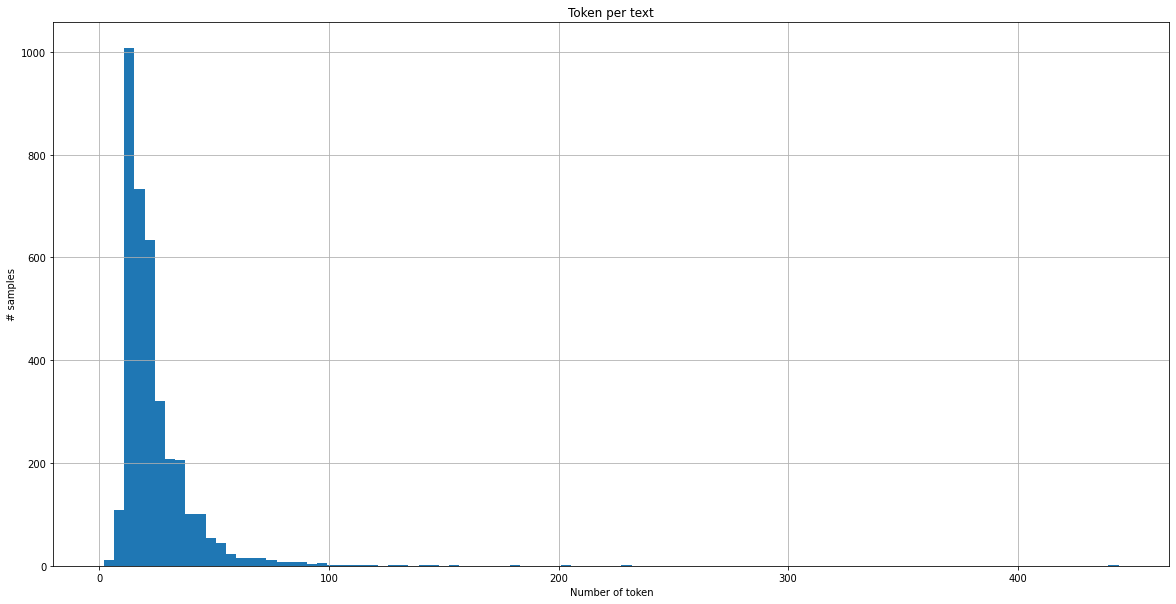

In [34]:
def plot_len_distribution(texts):
    plt.figure(figsize=(20, 10))
    plt.hist([len(text.split()) for text in texts], bins=100)
    plt.title('Token per text')
    plt.xlabel('Number of token')
    plt.ylabel('# samples')
    plt.grid(True)
    plt.show()

plot_len_distribution(data.sentence)

In [38]:
(data.sentence.apply(lambda x:len(x.split(' '))) > 128).sum()

8

## Params

In [ ]:
BATCHSIZE_TRAIN = 8
BATCHSIZE_VAL = 4
LEARNING_RATE = 5e-5
MAX_LEN = 128
NUM_EPOCH = 20
SEED = 42
NUM_CLASS = 5
MAX_GRAD_NORM = 1

## Data

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="./PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("./PhoBERT_base_transformers/dict.txt")

labels_to_ids = {'B-DES': 1, 'B-PRI': 3, 'I-DES': 2, 'I-PRI': 4, 'O': 0, 'X': -100}
ids_to_labels = {0: 'O', 1: 'B-DES', 2: 'I-DES', 3:'B-PRI', 4:'I-PRI'}

X, Y_label, Y_mask = convert_lines(
    data.sentence.values, 
    data.word_labels.values, 
    vocab, 
    bpe, 
    labels_to_ids, 
    max_sequence_length=MAX_LEN)

print('X shape: ', X.shape)
print('Y label shape', Y_label.shape)
print('Y mask shape', Y_mask.shape)

train_size = 0.8
def train_test_split(data, train_size):
    X_df = pd.DataFrame(data)
    X_train = X_df.sample(frac = train_size, random_state=200)
    X_test = X_df.drop(X_train.index).reset_index(drop=True)
    X_train = X_train.reset_index(drop=True)
    return X_train.values, X_test .values

X_train, X_test = train_test_split(X, train_size)
Y_label_train, Y_label_test = train_test_split(Y_label, train_size)
Y_mask_train, Y_mask_test = train_test_split(Y_mask, train_size)

class_weight = compute_class_weight(
    class_weight='balanced', 
    classes = np.array([0,1,2,3,4]), 
    y=Y_label_train.flatten()[Y_label_train.flatten()>=0])

print(class_weight)

100%|██████████| 3657/3657 [00:01<00:00, 3393.82it/s]

X shape:  (3657, 128)
Y label shape (3657, 128)
Y mask shape (3657, 128)
[ 0.24328616  1.55779008  6.52840909 15.97682503 31.33636364]


In [ ]:
train_dataset = TensorDataset(
    torch.tensor(X_train,dtype=torch.long), 
    torch.tensor(Y_label_train,dtype=torch.long)
    )
valid_dataset = TensorDataset(
    torch.tensor(X_test,dtype=torch.long), 
    torch.tensor(Y_label_test,dtype=torch.long)
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCHSIZE_TRAIN, 
    shuffle=True
    )
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=BATCHSIZE_VAL, 
    shuffle=False
    )

## Config

In [ ]:
class argu():
    def __init__(self):
        self.dict_path = "./PhoBERT_base_transformers/dict.txt"
        self.config_path = "./PhoBERT_base_transformers/config.json"
        self.max_sequence_length = MAX_LEN
        self.accumulation_steps = 1
        self.epochs = NUM_EPOCH
        self.seed = SEED
        self.bpe_codes = "./PhoBERT_base_transformers/bpe.codes"
args = argu()

config = RobertaConfig.from_pretrained(
    args.config_path,
    output_hidden_states=True,
    return_dict=True,
    num_labels=NUM_CLASS,
    pad_token_id = 1,
    bos_token_id = 0,
    eos_token_id = 2,
    attention_probs_dropout_prob = 0.1,
    classifier_dropout=0.5,
    gradient_checkpointing=False,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    hidden_size=768,
    initializer_range=0.02,
    intermediate_size=3072,
    layer_norm_eps=1e-05,
    max_position_embeddings=258,
    model_type="roberta",
    num_attention_heads=12,
    num_hidden_layers=12,
    position_embedding_type="absolute",
    tokenizer_class="PhobertTokenizer",
    transformers_version="4.15.0",
    type_vocab_size=1,
    use_cache=True,
    vocab_size=64001
)

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


In [ ]:
def train(epoch, verbose = False):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(train_loader):
        ids, labels = batch
        ids = ids.to(device)
        labels = labels.to(device)
        mask = ids!=1

        outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss = outputs[0]
        
        tr_logits = outputs[1]
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0 and verbose:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        try: 
            scheduler0.step()
        except:
            scheduler.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps

    labels = [ids_to_labels[id.item()] for id in tr_labels]
    predictions = [ids_to_labels[id.item()] for id in tr_preds]
    f1 = seqeval.metrics.f1_score([labels], [predictions])

    print(f"Training loss epoch: {epoch_loss}", f"Training F1 epoch: {f1}")

def valid(model, test_loader, verbose=False):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            
            ids, labels = batch
            ids = ids.to(device)
            labels = labels.to(device)
            mask = ids!=1 

            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = outputs[0]
            eval_logits = outputs[1]
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0 and verbose:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    f1 = seqeval.metrics.f1_score([labels], [predictions])
    print(f"Validation Loss: {eval_loss}", f"Validation F1: {f1}")

    return labels, predictions, f1

def train_crf(epoch, verbose = False):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    model.train()
    
    for idx, batch in enumerate(train_loader):
        ids, labels = batch
        ids = ids.to(device)
        labels = labels.to(device)
        mask = ids!=1
        
        outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss = outputs[0]
                
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0 and verbose:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        flattened_predictions = outputs[1].view(-1)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        try: 
            scheduler0.step()
        except:
            scheduler.step()
            
    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps

    labels = [ids_to_labels[id.item()] for id in tr_labels]
    predictions = [ids_to_labels[id.item()] for id in tr_preds]
    f1 = seqeval.metrics.f1_score([labels], [predictions])

    print(f"Training loss epoch: {epoch_loss}", f"Training F1 epoch: {f1}")

def valid_crf(model, test_loader, verbose=False):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            
            ids, labels = batch
            ids = ids.to(device)
            labels = labels.to(device)
            mask = ids!=1 

            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = outputs[0]
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0 and verbose:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            flattened_predictions = outputs[1].view(-1)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
            active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))

            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    # eval_accuracy = eval_accuracy / nb_eval_steps
    f1 = seqeval.metrics.f1_score([labels], [predictions])
    print(f"Validation Loss: {eval_loss}", f"Validation F1: {f1}")

    return labels, predictions, f1

## Default Phobert + Linear layer + Tiki dataset

In [ ]:
class RobertaForTokenClassification(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config, class_weight=None):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            if class_weight is not None:
                loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weight, dtype=torch.float).to(device))
            else: 
                loss_fct = nn.CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

checkpoint_path = './checkpoints/RobertaForTokenClassification_best.pth'
model = RobertaForTokenClassification.from_pretrained("vinai/phobert-base", config=config, class_weight=class_weight)
model.cuda()

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
num_train_optimization_steps = int(args.epochs*len(train_dataset)/BATCHSIZE_TRAIN/args.accumulation_steps)
optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=num_train_optimization_steps)  # PyTorch scheduler
# scheduler0 = get_constant_schedule(optimizer)  # PyTorch scheduler

print("Learning rate: ", LEARNING_RATE)
print("num_train_optimization_steps:", num_train_optimization_steps)

tsfm = model.roberta
for child in tsfm.children():
    for param in child.parameters():
        if not param.requires_grad:
            print("whoopsies")
        param.requires_grad = False
frozen = True

Learning rate:  5e-05
num_train_optimization_steps: 7315


In [ ]:
f1_best = 0
for epoch in range(NUM_EPOCH):
    if epoch > 0 and frozen:
        for child in tsfm.children():
            for param in child.parameters():
                param.requires_grad = True
        frozen = False
        try:
            del scheduler0
        except:
            pass
        torch.cuda.empty_cache()
    st = time.time()
    print(f"Training epoch: {epoch + 1}")
    train(epoch)
    labels, predictions, f1_val = valid(model, valid_loader)
    if f1_val > f1_best:
        f1_best = f1_val
        print(f'New best f1 {f1_best}')
        print(classification_report([labels], [predictions]))
    # save best model
    torch.save(model.state_dict(), checkpoint_path)
    for param_group in optimizer.param_groups:
        print('Current leanring rate: ',param_group['lr'])
    print('Time: ',time.time() - st)
    print('======================================================')

Training epoch: 1
Training loss epoch: 1.3817361876612804 Training F1 epoch: 0.21314087090856426
Validation Loss: 1.1099360878350304 Validation F1: 0.3970752261742471
New best f1 0.3970752261742471
              precision    recall  f1-score   support

         DES       0.31      0.66      0.42      2274
         PRI       0.13      0.53      0.21       182

   micro avg       0.29      0.65      0.40      2456
   macro avg       0.22      0.59      0.32      2456
weighted avg       0.30      0.65      0.41      2456

Current leanring rate:  4.815661815661816e-05
Current leanring rate:  4.815661815661816e-05
Time:  23.66596531867981
Training epoch: 2
Training loss epoch: 0.4276883712068933 Training F1 epoch: 0.6334981724360352
Validation Loss: 0.27126219238617705 Validation F1: 0.732488822652757
New best f1 0.732488822652757
              precision    recall  f1-score   support

         DES       0.70      0.80      0.75      2274
         PRI       0.44      0.75      0.55       182

## Phobert + LSTM + Linear + Tiki dataset

In [ ]:
class RobertaLSTM(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config, class_weight=None):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.bilstm = nn.LSTM(config.hidden_size, (config.hidden_size) // 2, dropout=0.1, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        lstm_output, hc = self.bilstm(sequence_output)
        logits = self.classifier(lstm_output)

        loss = None
        if labels is not None:
            if class_weight is not None:
                loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weight, dtype=torch.float).to(device))
            else: 
                loss_fct = nn.CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
class_weight

In [ ]:
model = RobertaLSTM.from_pretrained('vinai/phobert-base', num_labels=5, class_weight=class_weight)
model.to(device)

In [ ]:
# Creating optimizer and lr schedulers
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
num_train_optimization_steps = int(args.epochs*len(train_dataset)/BATCHSIZE_TRAIN/args.accumulation_steps)
optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=num_train_optimization_steps)  # PyTorch scheduler
scheduler0 = get_constant_schedule(optimizer)  # PyTorch scheduler


In [ ]:
tsfm = model.roberta
for child in tsfm.children():
    for param in child.parameters():
        if not param.requires_grad:
            print("whoopsies")
        param.requires_grad = False
frozen = True

In [ ]:
EPOCHS = 10
MAX_GRAD_NORM = 1
"""
Although LSTMs tend to not suffer from the vanishing gradient problem, they can have exploding gradients. Thus we enforced a hard constraint on the norm of the gradient [10,25] by scaling it when its norm exceeded a threshold. …"""
# It usually improves the training (and is pretty much always done in the fine-tuning scripts of research papers)
import time

for epoch in range(EPOCHS):
    if epoch > 0 and frozen:
        for child in tsfm.children():
            for param in child.parameters():
                param.requires_grad = True
        frozen = False
        del scheduler0
        torch.cuda.empty_cache()
    st = time.time()
    print(f"Training epoch: {epoch + 1}")
    train(epoch)
    labels, predictions = valid(model, valid_loader)
    
    print('Time: ',time.time() - st)

Training epoch: 1
Training loss epoch: 0.6089032675480582 Training F1 epoch: 0.43946262259952196
Validation Loss: 0.35876590766704797 Validation F1: 0.5721812434141201
Time:  39.062042236328125
Training epoch: 2
Training loss epoch: 0.3594023005812953 Training F1 epoch: 0.6321728361084354
Validation Loss: 0.16580462273047433 Validation F1: 0.8174217382850476
Time:  91.36617231369019
Training epoch: 3
Training loss epoch: 0.156797271983983 Training F1 epoch: 0.8203178991015895
Validation Loss: 0.1470461653162537 Validation F1: 0.8620826709062003
Time:  91.00090837478638
Training epoch: 4
Training loss epoch: 0.09983247618605713 Training F1 epoch: 0.8787376250062817
Validation Loss: 0.157449078767451 Validation F1: 0.874526231797327
Time:  91.34242296218872
Training epoch: 5
Training loss epoch: 0.07098762261079461 Training F1 epoch: 0.8970254027574366
Validation Loss: 0.16526996120530604 Validation F1: 0.9080530071355759
Time:  91.20107316970825
Training epoch: 6
Training loss epoch: 0.

## Phobert + CRF + Tiki dataset

In [ ]:
class RobertaCRF(RobertaPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)

        self.crf = CRF(num_tags=self.num_labels, batch_first=True)
        # self.post_init()
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            labels_copy = torch.clone(labels)
            labels_copy[labels==-100] = 0
            log_likelihood, tags = self.crf(logits, labels_copy), self.crf.decode(logits)
            loss = 0 - log_likelihood
        else:
            tags = self.crf.decode(logits)
        tags = torch.Tensor(tags)
        tags = tags.to(device)

        if not return_dict:
            output = (tags,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return loss, tags

In [ ]:
model = RobertaCRF.from_pretrained('vinai/phobert-base', num_labels=5)
model.cuda()

In [ ]:
# Creating optimizer and lr schedulers
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
num_train_optimization_steps = int(args.epochs*len(train_dataset)/args.batch_size/args.accumulation_steps)
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=num_train_optimization_steps)  # PyTorch scheduler
scheduler0 = get_constant_schedule(optimizer)  # PyTorch scheduler

tsfm = model.roberta
for child in tsfm.children():
    for param in child.parameters():
        if not param.requires_grad:
            print("whoopsies")
        param.requires_grad = False
frozen = True

EPOCHS = 10
MAX_GRAD_NORM = 10

import time

for epoch in range(EPOCHS):
    if epoch > 0 and frozen:
        for child in tsfm.children():
            for param in child.parameters():
                param.requires_grad = True
        frozen = False
        del scheduler0
        torch.cuda.empty_cache()
    st = time.time()
    print(f"Training epoch: {epoch + 1}")
    train_modified(epoch)
    labels, predictions = valid_modified(model, valid_loader)
    
    print('Time: ',time.time() - st)

Training epoch: 1


/usr/local/lib/python3.7/dist-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:328.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Training loss epoch: 141.1873681949136 Training F1 epoch: 0.010669715156711442
Validation Loss: 30.532176116776597 Validation F1: 0.0016253555465258025
Time:  341.531724691391
Training epoch: 2
Training loss epoch: 16.23040179476712 Training F1 epoch: 0.7982217573221758
Validation Loss: 4.768356740148993 Validation F1: 0.8821261919253398
Time:  412.92261958122253
Training epoch: 3
Training loss epoch: 6.580289830275572 Training F1 epoch: 0.9179917626818206
Validation Loss: 3.6424914083845628 Validation F1: 0.925264012997563
Time:  411.90776658058167
Training epoch: 4
Training loss epoch: 4.381463306197703 Training F1 epoch: 0.9429851990827601
Validation Loss: 3.985554846258111 Validation F1: 0.915184958103413
Time:  412.2711532115936
Training epoch: 5
Training loss epoch: 3.25973218907424 Training F1 epoch: 0.9550573514077164
Validation Loss: 3.832001232710041 Validation F1: 0.9256097560975609
Time:  412.1608827114105
Training epoch: 6
Training loss epoch: 3.1167723442035946 Training F

## Phobert + LSTM + CRF + Tiki dataset

https://github.com/hemingkx/CLUENER2020/tree/main/BERT-Softmax

In [ ]:
class RobertaLSTMCRF(RobertaPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.bilstm = nn.LSTM(config.hidden_size, (config.hidden_size) // 2, dropout=0.5, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)

        self.crf = CRF(num_tags=self.num_labels, batch_first=True)
        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        lstm_output, hc = self.bilstm(sequence_output)
        logits = self.classifier(lstm_output)

        loss = None
        if labels is not None:
            labels[labels==-100] = 0
            log_likelihood, tags = self.crf(logits, labels), self.crf.decode(logits)
            loss = 0 - log_likelihood
        else:
            tags = self.crf.decode(logits)
        tags = torch.Tensor(tags)
        tags = tags.to(device)

        if not return_dict:
            output = (tags,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return loss, tags

checkpoint_path = './checkpoints/RobertaLSTMCRF.pth'
model = RobertaLSTMCRF.from_pretrained('vinai/phobert-base', config=config)
model.cuda()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaLSTMCRF: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaLSTMCRF from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaLSTMCRF from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

RobertaLSTMCRF(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
num_train_optimization_steps = int(args.epochs*len(train_dataset)/BATCHSIZE_TRAIN/args.accumulation_steps)
optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=num_train_optimization_steps)  # PyTorch scheduler
# scheduler0 = get_constant_schedule(optimizer)  # PyTorch scheduler

print("Learning rate: ", LEARNING_RATE)
print("num_train_optimization_steps:", num_train_optimization_steps)

tsfm = model.roberta
for child in tsfm.children():
    for param in child.parameters():
        if not param.requires_grad:
            print("whoopsies")
        param.requires_grad = False
frozen = True

Learning rate:  5e-05
num_train_optimization_steps: 7315


In [ ]:
f1_best = 0
for epoch in range(NUM_EPOCH):
    if epoch > 0 and frozen:
        for child in tsfm.children():
            for param in child.parameters():
                param.requires_grad = True
        frozen = False
        try:
            del scheduler0
        except:
            pass
        torch.cuda.empty_cache()
    st = time.time()
    print(f"Training epoch: {epoch + 1}")
    train_crf(epoch)
    labels, predictions, f1_val = valid_crf(model, valid_loader)
    if f1_val > f1_best:
        f1_best = f1_val
        print(f'New best f1 {f1_best}')
        print(classification_report([labels], [predictions]))
    # save best model
    torch.save(model.state_dict(), checkpoint_path)
    for param_group in optimizer.param_groups:
        print('Current leanring rate: ',param_group['lr'])
    print('Time: ',time.time() - st)
    print('======================================================')

Training epoch: 1
Training loss epoch: 203.42970838703093 Training F1 epoch: 0.06472942404732905
Validation Loss: 37.71274921021175 Validation F1: 0.4856804733727811
New best f1 0.4856804733727811


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         DES       0.58      0.45      0.51      2276
         PRI       0.00      0.00      0.00       182

   micro avg       0.58      0.42      0.49      2458
   macro avg       0.29      0.23      0.25      2458
weighted avg       0.54      0.42      0.47      2458

Current leanring rate:  4.815661815661816e-05
Current leanring rate:  4.815661815661816e-05
Time:  92.46463394165039
Training epoch: 2
Training loss epoch: 33.295401734732536 Training F1 epoch: 0.7569843878389483
Validation Loss: 10.109715863003757 Validation F1: 0.8772993733575905
New best f1 0.8772993733575905
              precision    recall  f1-score   support

         DES       0.89      0.89      0.89      2276
         PRI       0.67      0.74      0.70       182

   micro avg       0.87      0.88      0.88      2458
   macro avg       0.78      0.82      0.80      2458
weighted avg       0.87      0.88      0.88      2458

Current leanring rate:  4.562023

# Temp


In [ ]:
from vncorenlp import VnCoreNLP

# To perform word segmentation, POS tagging, NER and then dependency parsing
annotator = VnCoreNLP("/content/VnCoreNLP/VnCoreNLP-1.1.1.jar", annotators="wseg,pos,ner,parse", max_heap_size='-Xmx2g') 
 
    
# Input 
text = "Ông Nguyễn Khắc Chúc  đang làm việc tại Đại học Quốc gia Hà Nội. Bà Lan, vợ ông Chúc, cũng làm việc tại đây."

# To perform word segmentation, POS tagging, NER and then dependency parsing
annotated_text = annotator.annotate(text)

# To perform word segmentation only
word_segmented_text = annotator.tokenize(text) 


In [ ]:
# Input 
text = "thô lỗ"

# To perform word segmentation, POS tagging, NER and then dependency parsing
annotated_text = annotator.annotate(text)

# To perform word segmentation only
word_segmented_text = annotator.tokenize(text) 
word_segmented_text

[['thô_lỗ']]

In [ ]:
lines = ['mua được giá tốt lại được freeship mừng rơi nước_mắt đối_với tỉnh_lẻ thì tiền ship là 1 trở_ngại sản_phẩm quá ổn cảm_ơn shop cảm_ơn tiki this is english sentences cảm_ơn'] 
tags = ['O,O,B-PRI,O,O,O,B-PRI,O,O,O,O,O,O,B-PRI,I-PRI,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O']

ids, labels, masks = convert_lines(lines, tags, vocab, bpe, labels_to_ids)
for item in zip(ids[0], labels[0], masks[0]):
    print(f'{item[0]} \t {item[1]} \t {item[2]}')

## Data - legacy



In [ ]:
# data_path = './data/seq_tag/tokens_labeled_final.xlsx'
data_path = './data/seq_tag/tokens_labeled_no_whitelist.csv'
data = prepare_dataset(data_path)
data.head(10)

In [ ]:
path = data_path
if path.split('.')[-1]=='xlsx':
    with open(path, 'rb') as f:
        data = pd.read_excel(f)
else:
    data = pd.read_csv(path, encoding='utf-8')
data.drop(columns=['Unnamed: 0'], inplace=True)

data.rename(columns={'sentence': 'Sentence #', 'tokens': 'Word', 'tag': 'Tag'}, inplace=True)
print(data.shape)
label = pd.read_csv('./data/seq_tag/tokens_labeled_sentiment.csv')

print(label.shape)
# data['label'] =


In [ ]:
data['Sentence #'] = data['Sentence #'].apply(lambda x: f'Sentence: {int(x+1)}')

print("Number of tags: {}".format(len(data.Tag.unique())))

frequencies = data.Tag.value_counts()
tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

labels_to_ids = {k: v for v, k in enumerate(data.Tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(data.Tag.unique())}
print(labels_to_ids)

data = data.fillna(method='ffill')
print(data)
if path.split('.')[-1]=='csv':
    data['sentence'] = data[['Sentence #','Word','Tag', 'label']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
    data['word_labels'] = data[['Sentence #','Word','Tag', 'label']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
if path.split('.')[-1]=='xlsx':
    data['sentence'] = data.groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(str(v) for v in x))
    data['word_labels'] = data.groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(str(v) for v in x))
    # data['label'] = data.groupby(['Sentence #'])['label'].mean()
data = data.drop_duplicates(subset='sentence').reset_index(drop=True)


In [ ]:
label = []
for sent in data['Sentence #']:
    sent_id = int(sent.split(' ')[-1])
    label.append(df.label.iloc[sent_id-1])

In [ ]:
df = pd.read_excel('./data/clean/final6.xlsx')
df.drop(columns='Unnamed: 0', inplace=True)
df

In [ ]:
data['label'] = label

In [ ]:
# data.drop(columns=['Sentence #','Word','Tag'], inplace=True)
data.drop_duplicates(inplace=True)
data

In [ ]:
data.to_csv('./data/joint/data_joint.csv')